In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import multiclass
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D, Activation, SpatialDropout1D, LSTM, SimpleRNN, GRU
from keras.optimizers import Adam, SGD, RMSprop
from keras import losses, optimizers
from keras import preprocessing
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

import tensorflow as tf

Izvršićemo klasifikaciju podataka neurnoskim mrežama za 2 kategorije. Učitaćemo podatke i odraditi vektorizaciju, a zatim podeliti na podatke na trening, test i validacione skupove. Isprobavali smo različite vrednosti za parametre modela (units, epochs, batch_size, learning_rate) kao i broj slojeva i za ove vrednosti smo dobili najbolje moguće modele za naše podatke.

Funkcija <i>GetData</i> će nam služiti za učitavanje podataka u zavisnosti od broja kategorija.

In [2]:
def GetData(num_of_categories, categories):
    news = pd.read_csv('data/vesti.csv')
    if num_of_categories == 36:
        X = news['text']
        y = news['category']
    else:
        news = news[news.category.isin(categories)]
        X = news['text']
        y = news['category']
        
    return (X, y)

Funkcija <i>EvaluateModel</i> će služiti za evaluaciju podataka na test skupu i vizualizaciju dobijenih vrednosti funkcije greške i tačnosti.

In [3]:
def EvaluateModel(model, X_test, y_test, history):
    score = model.evaluate(X_test, y_test)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])
    
    epochs = history.epoch
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12,8))
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs, loss, c='red', label = 'training')
    plt.plot(epochs, validation_loss, c='orange', label='validation')
    plt.legend(loc = 'best')
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs, accuracy, c='red', label = 'training')
    plt.plot(epochs, validation_accuracy, c = 'orange', label = 'validation')
    plt.legend(loc = 'best')
    plt.show()

Funkcija <i>TransformToTensor</i> izvrsava dekompoziciju pomocu TruncatedSVD algoritma i proveravamo variansu kako bismo ocuvali smisao podataka, zatim na kraju pretvaramo transformisane podatke u tenzor kako bismo mogli da pokrenemo modele.

In [4]:
def TransformToTensor(X, n):
    pca = decomposition.TruncatedSVD(n_components=n, random_state=4)
    pca.fit(X)
    print(sum(pca.explained_variance_ratio_))
    X = pca.transform(X)
    return tf.convert_to_tensor(X)

### Klasifikacija za 2 kategorije

Učitavamo podatke za dve kategorije koje imaju najveći broj članaka u skupu.

In [5]:
categories2 = ['SPORTS', 'WOMEN']
X2, y2 = GetData(2, categories2)
print(X2.shape)
print(y2.shape)

(8239,)
(8239,)


Delimo podatke na trening, test i validacioni skup, a zatim ih transformišemo pomoću funkcije TransformData.

In [6]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X2, y2, test_size = 0.2, stratify = y2, random_state = 4)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size = 0.3, stratify = y_train_validation, random_state = 4)

In [7]:
vectorizer1 = feature_extraction.text.TfidfVectorizer(min_df=0)
vectorizer1.fit(X_train_validation.values.astype('U'))
X2_test = vectorizer1.transform(X_test.values.astype('U'))

vectorizer2 = feature_extraction.text.TfidfVectorizer(min_df=0)
vectorizer2.fit(X_train.values.astype('U'))
X2_train = vectorizer2.transform(X_train.values.astype('U'))
X2_validation = vectorizer2.transform(X_validation.values.astype('U'))

In [8]:
X2_train_transformed = TransformToTensor(X2_train, 1200)
X2_validation_transformed = TransformToTensor(X2_validation, 1200)
X2_test_transformed = TransformToTensor(X2_test, 1200)

0.6673107108974641
0.8814342738629093
0.9202627546467723


In [9]:
y2_test_transformed = pd.get_dummies(y_test).values
y2_train_transformed = pd.get_dummies(y_train).values
y2_validation_transformed = pd.get_dummies(y_validation).values

Kreiramo modele i zatim prikazujemo rezultate.

In [10]:
model1 = Sequential()
model1.add(Embedding(input_dim = 2000, output_dim = 32, input_length = X2_train_transformed.shape[1]))
model1.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))
model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer = SGD(learning_rate = 0.0001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 32)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 88,962
Trainable params: 88,962
Non-trainable params: 0
_________________________________________________________________


In [11]:
history1 = model1.fit(X2_train_transformed, y2_train_transformed, epochs=10, batch_size=32, validation_data=(X2_validation_transformed, y2_validation_transformed))

Epoch 1/10
145/145 [==============================] - 181s 1s/step - loss: 0.6925 - accuracy: 0.5773 - val_loss: 0.6920 - val_accuracy: 0.5925
Epoch 2/10
145/145 [==============================] - 172s 1s/step - loss: 0.6917 - accuracy: 0.5922 - val_loss: 0.6913 - val_accuracy: 0.5925
Epoch 3/10
145/145 [==============================] - 171s 1s/step - loss: 0.6909 - accuracy: 0.5922 - val_loss: 0.6905 - val_accuracy: 0.5925
Epoch 4/10
145/145 [==============================] - 168s 1s/step - loss: 0.6902 - accuracy: 0.5922 - val_loss: 0.6898 - val_accuracy: 0.5925
Epoch 5/10
145/145 [==============================] - 169s 1s/step - loss: 0.6895 - accuracy: 0.5922 - val_loss: 0.6891 - val_accuracy: 0.5925
Epoch 6/10
145/145 [==============================] - 170s 1s/step - loss: 0.6889 - accuracy: 0.5922 - val_loss: 0.6885 - val_accuracy: 0.5925
Epoch 7/10
145/145 [==============================] - 172s 1s/step - loss: 0.6883 - accuracy: 0.5922 - val_loss: 0.6879 - val_accuracy: 0.5925

52/52 [==============================] - 7s 127ms/step - loss: 0.6863 - accuracy: 0.5922
Test loss:  0.6863033771514893
Test accuracy:  0.5922330021858215


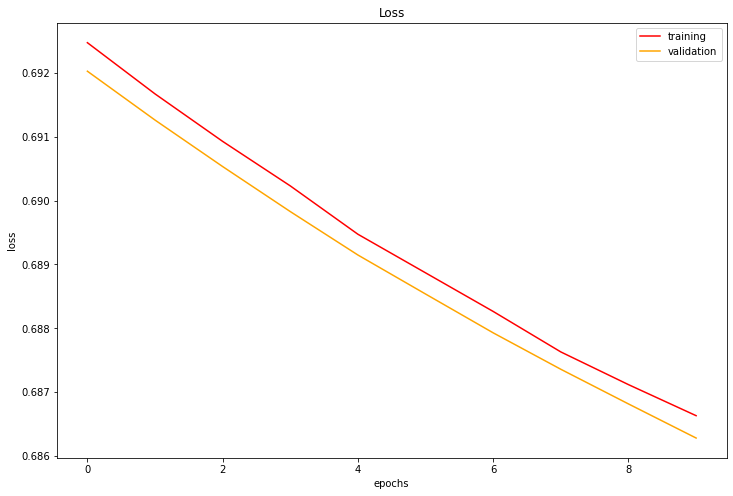

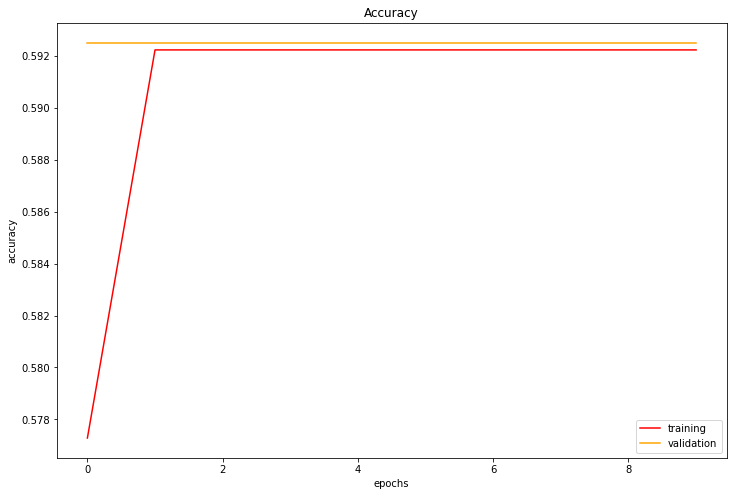

In [12]:
EvaluateModel(model1, X2_test_transformed, y2_test_transformed, history1)

In [13]:
p1 = model1.predict_classes(X2_test_transformed, verbose=0)
print(metrics.classification_report(np.argmax(y2_test_transformed, axis=1), p1))
print(metrics.confusion_matrix(np.argmax(y2_test_transformed, axis=1), p1))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       976
           1       0.00      0.00      0.00       672

    accuracy                           0.59      1648
   macro avg       0.30      0.50      0.37      1648
weighted avg       0.35      0.59      0.44      1648

[[976   0]
 [672   0]]


c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
model2 = Sequential()
model2.add(Embedding(input_dim = 2000, output_dim = 32, input_length = X2_train_transformed.shape[1]))
model2.add(GRU(64))
model2.add(Dense(2, activation='softmax'))

model2.compile(optimizer = Adam(learning_rate = 0.0001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1200, 32)          64000     
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 82,946
Trainable params: 82,946
Non-trainable params: 0
_________________________________________________________________


In [15]:
history2 = model2.fit(X2_train_transformed, y2_train_transformed, epochs=8, batch_size=32, validation_data=(X2_validation_transformed, y2_validation_transformed))

Epoch 1/8
145/145 [==============================] - 79s 548ms/step - loss: 0.6802 - accuracy: 0.5922 - val_loss: 0.6759 - val_accuracy: 0.5925
Epoch 2/8
145/145 [==============================] - 76s 521ms/step - loss: 0.6766 - accuracy: 0.5922 - val_loss: 0.6759 - val_accuracy: 0.5925
Epoch 3/8
145/145 [==============================] - 77s 534ms/step - loss: 0.6764 - accuracy: 0.5922 - val_loss: 0.6759 - val_accuracy: 0.5925
Epoch 4/8
145/145 [==============================] - 78s 538ms/step - loss: 0.6762 - accuracy: 0.5922 - val_loss: 0.6760 - val_accuracy: 0.5925
Epoch 5/8
145/145 [==============================] - 77s 532ms/step - loss: 0.6762 - accuracy: 0.5922 - val_loss: 0.6759 - val_accuracy: 0.5925
Epoch 6/8
145/145 [==============================] - 75s 517ms/step - loss: 0.6762 - accuracy: 0.5922 - val_loss: 0.6760 - val_accuracy: 0.5925
Epoch 7/8
145/145 [==============================] - 74s 513ms/step - loss: 0.6762 - accuracy: 0.5922 - val_loss: 0.6761 - val_accuracy:

52/52 [==============================] - 6s 107ms/step - loss: 0.6760 - accuracy: 0.5922
Test loss:  0.6760405898094177
Test accuracy:  0.5922330021858215


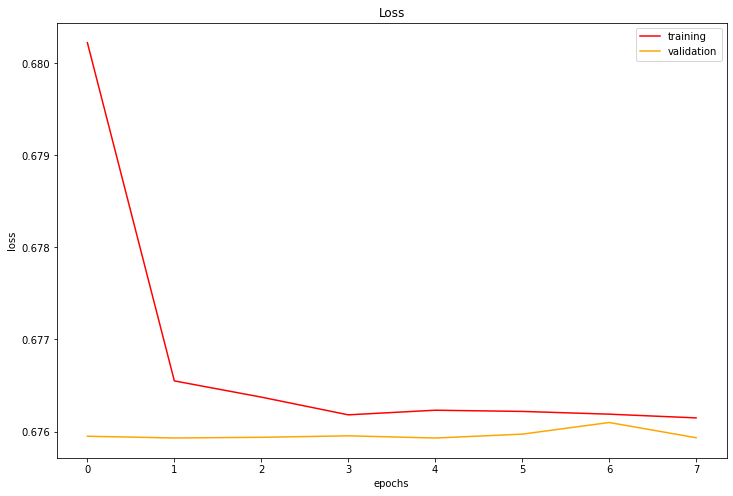

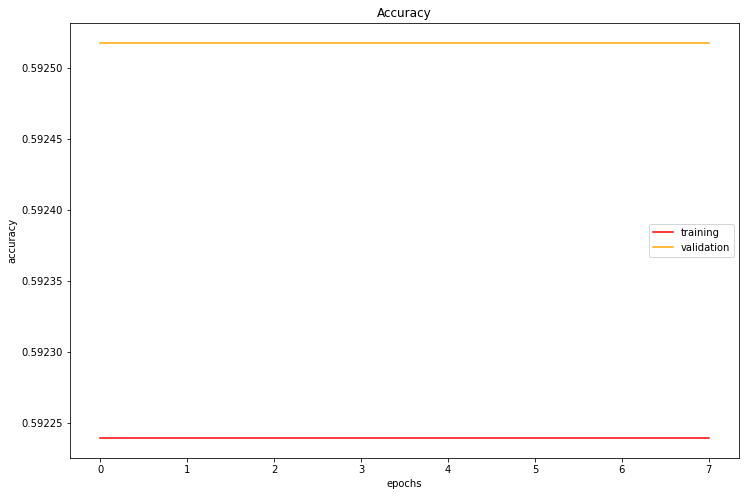

In [16]:
EvaluateModel(model2, X2_test_transformed, y2_test_transformed, history2)

In [17]:
p2 = model2.predict_classes(X2_test_transformed, verbose=0)
print(metrics.classification_report(np.argmax(y2_test_transformed, axis=1), p2))
print(metrics.confusion_matrix(np.argmax(y2_test_transformed, axis=1), p2))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       976
           1       0.00      0.00      0.00       672

    accuracy                           0.59      1648
   macro avg       0.30      0.50      0.37      1648
weighted avg       0.35      0.59      0.44      1648

[[976   0]
 [672   0]]
